# Practice for Midterm 2

This practice for Midterm 2 is comprised of optional sections from two earlier labs. Be sure to run the setup cell first.


In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter('ignore', UserWarning)

from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# These lines load the tests.
from gofer.ok import check

### 1. Reading Sign Language with Classification (from Lab 12)

Brazilian Sign Language is a visual language used primarily by Brazilians who are deaf.  It is more commonly called Libras.  People who communicate with visual language are called *signers*.  Here is a video of someone signing in Libras:

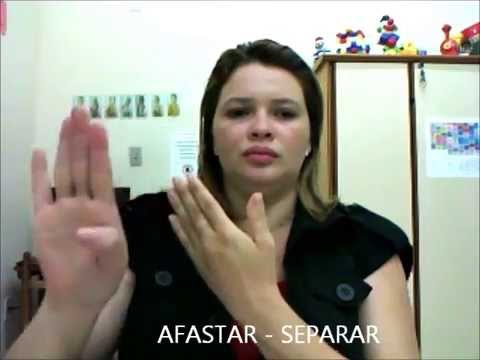

In [2]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo("mhIcuMZmyWM")

Programs like Siri or Google Now begin the process of understanding human speech by classifying short clips of raw sound into basic categories called *phones*.  For example, the recorded sound of someone saying the word "robot" might be broken down into several phones: "rrr", "oh", "buh", "aah", and "tuh".  Phones are then grouped together into further categories like words ("robot") and sentences ("I, for one, welcome our new robot overlords") that carry more meaning.

A visual language like Libras has an analogous structure.  Instead of phones, each word is made up of several *hand movements*.  As a first step in interpreting Libras, we can break down a video clip into small segments, each containing a single hand movement.  The task is then to figure out what hand movement each segment represents.

We can do that with classification!

The [data](https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.names) in this exercise come from Dias, Peres, and Biscaro, researchers at the University of Sao Paulo in Brazil.  They identified 15 distinct hand movements in Libras (probably an oversimplification, but a useful one) and captured short videos of signers making those hand movements.  (You can read more about their work [here](http://ieeexplore.ieee.org/Xplore/login.jsp?url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F5161636%2F5178557%2F05178917.pdf&authDecision=-203). The paper is gated, so you will need to use your institution's Wi-Fi or VPN to access it.)

For each video, they chose 45 still frames from the video and identified the location (in horizontal and vertical coordinates) of the signer's hand in each frame.  Since there are two coordinates for each frame, this gives us a total of 90 numbers summarizing how a hand moved in each video.  Those 90 numbers will be our *attributes*.

Each video is *labeled* with the kind of hand movement the signer was making in it.  Each label is one of 15 strings like "horizontal swing" or "vertical zigzag".

For simplicity, we're going to focus on distinguishing between just two kinds of movements: "horizontal straight-line" and "vertical straight-line".  We took the Sao Paulo researchers' original dataset, which was quite small, and used some simple techniques to create a much larger synthetic dataset.

These data are in the file `movements.csv`.  Run the next cell to load it.

In [3]:
movements = Table.read_table("movements.csv")
movements.take(np.arange(5))

Frame 1 x,Frame 1 y,Frame 2 x,Frame 2 y,Frame 3 x,Frame 3 y,Frame 4 x,Frame 4 y,Frame 5 x,Frame 5 y,Frame 6 x,Frame 6 y,Frame 7 x,Frame 7 y,Frame 8 x,Frame 8 y,Frame 9 x,Frame 9 y,Frame 10 x,Frame 10 y,Frame 11 x,Frame 11 y,Frame 12 x,Frame 12 y,Frame 13 x,Frame 13 y,Frame 14 x,Frame 14 y,Frame 15 x,Frame 15 y,Frame 16 x,Frame 16 y,Frame 17 x,Frame 17 y,Frame 18 x,Frame 18 y,Frame 19 x,Frame 19 y,Frame 20 x,Frame 20 y,Frame 21 x,Frame 21 y,Frame 22 x,Frame 22 y,Frame 23 x,Frame 23 y,Frame 24 x,Frame 24 y,Frame 25 x,Frame 25 y,Frame 26 x,Frame 26 y,Frame 27 x,Frame 27 y,Frame 28 x,Frame 28 y,Frame 29 x,Frame 29 y,Frame 30 x,Frame 30 y,Frame 31 x,Frame 31 y,Frame 32 x,Frame 32 y,Frame 33 x,Frame 33 y,Frame 34 x,Frame 34 y,Frame 35 x,Frame 35 y,Frame 36 x,Frame 36 y,Frame 37 x,Frame 37 y,Frame 38 x,Frame 38 y,Frame 39 x,Frame 39 y,Frame 40 x,Frame 40 y,Frame 41 x,Frame 41 y,Frame 42 x,Frame 42 y,Frame 43 x,Frame 43 y,Frame 44 x,Frame 44 y,Frame 45 x,Frame 45 y,Movement type
0.522768,0.769731,0.536186,0.749446,0.518625,0.757197,0.517752,0.756847,0.504951,0.726008,0.50008,0.712113,0.463555,0.712355,0.49873,0.736872,0.51472,0.754353,0.517935,0.748163,0.5082,0.734278,0.50004,0.726941,0.49291,0.71189,0.480587,0.715755,0.476772,0.723531,0.504372,0.717318,0.46351,0.70031,0.463217,0.693279,0.474777,0.722122,0.512079,0.73267,0.506785,0.731242,0.497417,0.723703,0.505879,0.726615,0.51537,0.741874,0.544376,0.741177,0.51367,0.714379,0.509508,0.715222,0.519559,0.704945,0.511828,0.69361,0.511366,0.685024,0.510194,0.686122,0.518486,0.694125,0.524232,0.68817,0.531254,0.672905,0.530833,0.672029,0.521013,0.621037,0.481328,0.586983,0.450996,0.576725,0.474634,0.585757,0.465209,0.572517,0.430172,0.547155,0.429693,0.531896,0.415799,0.516734,0.40249,0.528653,0.413692,0.510434,vertical straight-line
0.179546,0.658986,0.177132,0.656834,0.168157,0.664803,0.176407,0.654713,0.167577,0.635559,0.138276,0.633621,0.143817,0.633303,0.154967,0.643993,0.169151,0.646888,0.138409,0.62286,0.141052,0.638818,0.129957,0.644284,0.141763,0.643459,0.127024,0.641122,0.133745,0.63458,0.114496,0.632741,0.0891234,0.631917,0.0836099,0.630901,0.07445,0.621396,0.072605,0.635247,0.0506362,0.620064,0.0467104,0.62067,0.0531715,0.645212,0.0374171,0.634352,0.0182681,0.61547,-0.0197023,0.6088,-0.027299,0.605641,-0.0482872,0.594468,-0.0640002,0.588416,-0.0565593,0.582703,-0.0881633,0.586423,-0.0929613,0.600561,-0.0928198,0.609785,-0.107121,0.624372,-0.115449,0.613028,-0.140709,0.614448,-0.148999,0.607538,-0.179288,0.582983,-0.196426,0.612175,-0.195264,0.580151,-0.230368,0.577835,-0.250168,0.550737,-0.274717,0.571828,-0.258795,0.590663,-0.256045,0.578798,horizontal straight-line
0.805813,0.651365,0.832204,0.666023,0.834636,0.645757,0.826685,0.645685,0.816671,0.625701,0.810289,0.637001,0.819373,0.635922,0.827567,0.637587,0.813763,0.645346,0.824472,0.632012,0.82673,0.643524,0.817462,0.638418,0.804468,0.63604,0.830122,0.652033,0.828967,0.658297,0.850648,0.678696,0.845375,0.679893,0.858148,0.677961,0.852067,0.673301,0.849921,0.668893,0.84142,0.681652,0.869216,0.68519,0.857929,0.69222,0.868462,0.683252,0.843773,0.668541,0.848835,0.674522,0.843266,0.663946,0.830001,0.655817,0.825753,0.654858,0.822624,0.660058,0.818284,0.643763,0.796939,0.62913,0.789691,0.61749,0.772315,0.606656,0.773609,0.605172,0.76006,0.579637,0.728993,0.576794,0.726034,0.584777,0.705394,0.573393,0.693345,0.579456,0.693249,0.581378,0.684606,0.576406,0.670061,0.566151,0.642557,0.569876,0.629915,0.561387,horizontal straight-line
0.83942,0.564511,0.853031,0.560031,0.845024,0.549989,0.824814,0.546812,0.821869,0.5462,0.820898,0.536278,0.800887,0.525634,0.801667,0.542531,0.806793,0.553656,0.799924,0.576862,0.810348,0.571102,0.801704,0.57294,0.773529,0.561476,0.772628,0.565349,0.773298,0.566374,0.727042,0.553929,0.723279,0.579006,0.731698,0.593158,0.727945,0.606501,0.72577,0.644594,0.721218,0.642742,0.718306,0.65346,0.702917,0.676261,0.724201,0.707004,0.711995,0.708004,0.703505,0.708526,0.697355,0.711636,0.674235,0.737123,0.68839,0.

The cell below displays movements graphically.  Run it and use the slider to answer the next question.

In [4]:
# Just run this cell and use the slider it produces.
def display_whole_movement(row_idx):
    num_frames = int((movements.num_columns-1)/2)
    row = np.array(movements.drop("Movement type").row(row_idx))
    xs = row[np.arange(0, 2*num_frames, 2)]
    ys = row[np.arange(1, 2*num_frames, 2)]
    plt.figure(figsize=(5,5))
    plt.plot(xs, ys, c="gold")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-.5, 1.5)
    plt.ylim(-.5, 1.5)
    plt.gca().set_aspect('equal', adjustable='box')

def display_hand(example, frame, display_truth):
        time_idx = frame-1
        display_whole_movement(example)
        x = movements.column(2*time_idx).item(example)
        y = movements.column(2*time_idx+1).item(example)
        plt.annotate(
            "frame {:d}".format(frame),
            xy=(x, y), xytext=(-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            color='white',
            bbox = {'boxstyle': 'round,pad=0.5', 'fc': 'black', 'alpha':.4},
            arrowprops = {'arrowstyle': '->', 'connectionstyle':'arc3,rad=0', 'color': 'black'})
        plt.scatter(x, y, c="black", zorder=10)
        plt.title("Hand positions for movement {:d}{}".format(example, "\n(True class: {})".format(movements.column("Movement type").item(example)) if display_truth else ""))

def animate_movement():
    interact(
        display_hand,
        example=widgets.BoundedIntText(min=0, max=movements.num_rows-1, value=0, msg_throttle=1),
        frame=widgets.IntSlider(min=1, max=int((movements.num_columns-1)/2), step=1, value=1, msg_throttle=1),
        display_truth=fixed(False))

animate_movement()

interactive(children=(BoundedIntText(value=0, description='example', max=959), IntSlider(value=1, description=…

<div class="hide">\pagebreak</div>

#### Question 1

Before we move on, check your understanding of the dataset.  Judging by the plot, is the first movement example a vertical motion, or a horizontal motion? If it is hard to tell, does it seem more likely to be vertical or horizontal? This is the kind of question a classifier has to answer.  Find out the right answer by looking at the `"Movement type"` column.  

Assign `first_movement` to `1` if the movement was vertical, or `2` if the movement was horizontal.

In [5]:
first_movement = ...

In [6]:
check('part3_tests/q1_1.py')

### Splitting the dataset
We'll do 2 different kinds of things with the `movements` dataset:
1. We'll build a classifier that uses the movements with known labels as examples to classify similar movements.  This is called *training*.
2. We'll evaluate or *test* the accuracy of the classifier we build.

For reasons discussed in lecture and the textbook, we want to use separate datasets for these two purposes.  So we split up our one dataset into two.

<div class="hide">\pagebreak</div>

#### Question 2

Create a table called `train_movements` and another table called `test_movements`.  `train_movements` should include the first $\frac{11}{16}$th of the rows in `movements` (rounded to the nearest integer), and `test_movements` should include the remaining $\frac{5}{16}$th. 

Note that we do **not** mean the first 11 rows for the training test and rows 12-16 for the test set. We mean the first $\frac{11}{16} = 68.75$% of the table should be for the the trianing set, and the rest should be for the test set. 

*Hint:* Use the table method `take`.

In [7]:
training_proportion = 11/16
num_movements = movements.num_rows
num_train = int(round(num_movements * training_proportion))

train_movements = ...
test_movements = ...

print("Training set:\t",   train_movements.num_rows, "examples")
print("Test set:\t",       test_movements.num_rows, "examples")

AttributeError: 'ellipsis' object has no attribute 'num_rows'

In [8]:
check('part3_tests/q1_2.py')

### Using only 2 features
First let's see how well we can distinguish two movements (a vertical line and a horizontal line) using the hand position from just a single frame (without the other 44).

<div class="hide">\pagebreak</div>

#### Question 3

Make a table called `train_two_features` with only 3 columns: the first frame’s x coordinate and first frame’s y coordinate are our chosen features, as well as the movement type; only the examples in `train_movements`. 

In [9]:
train_two_features = ...
train_two_features

Ellipsis

In [10]:
check('part3_tests/q1_3.py')

Now we want to make a scatter plot of the frame coordinates, where the dots for horizontal straight-line movements have one color and the dots for vertical straight-line movements have another color.  Here is a scatter plot without colors:

In [11]:
train_two_features.scatter("Frame 1 x", "Frame 1 y")

AttributeError: 'ellipsis' object has no attribute 'scatter'

This isn't useful because we don't know which dots are which movement type.  We need to tell Python how to color the dots.  Let's use gold for vertical and blue for horizontal movements.

`scatter` takes an extra argument called `colors` that's the name of an extra column in the table that contains colors (strings like "red" or "orange") for each row.  So we need to create a table like this:

|Frame 1 x|Frame 1 y|Movement type|Color|
|-|-|-|-|
|0.522768|0.769731|vertical straight-line|gold|
|0.179546|0.658986|horizontal straight-line|blue|
|...|...|...|...|

<div class="hide">\pagebreak</div>

#### Question 4

In the cell below, create a table named `with_colors`.  It should have the same columns as the example table above, but with a row for each row in `train_two_features`. Then, create a scatter plot of your data.

In [12]:
# You should find the following table useful.
type_to_color = Table().with_columns(
    "Movement type", make_array("vertical straight-line", "horizontal straight-line"),
    "Color",         make_array("gold",                   "blue"))

with_colors = ...
with_colors.scatter("Frame 1 x", "Frame 1 y", colors="Color")

AttributeError: 'ellipsis' object has no attribute 'scatter'

<div class="hide">\pagebreak</div>

#### Question 5

Based on the scatter plot, how well will a nearest-neighbor classifier based on only these 2 features (the x- and y-coordinates of the hand position in the first frame) work?  Will it:

1. distinguish almost perfectly between vertical and horizontal movements;
2. distinguish somewhat well between vertical and horizontal movements, getting some correct but missing a substantial proportion; or
3. be basically useless in distinguishing between vertical and horizontal movements?

Why?

*Write your answer here, replacing this text.*

### 2. Finding the Bootstrap Confidence Interval for the True Slope (From Lab 11)

We're going to use the faithful dataset. Last time we looked at this dataset, we noticed the apparent linear relationship between duration and wait, and we decided to use regression to predict wait in terms of duration. However, our data are just a sample of all the eruptions that have happened at Old Faithful. As we know, relationships can appear in a sample that don't really exist in the population from which the sample was taken. Run the cell below to load the dataset and some of the functions you defined in earlier questions from Lab 11.

duration,wait
3.6,79
3.333,74
4.533,85
4.7,88
3.6,85
4.35,85
3.917,84
4.2,78
4.7,83
4.8,84


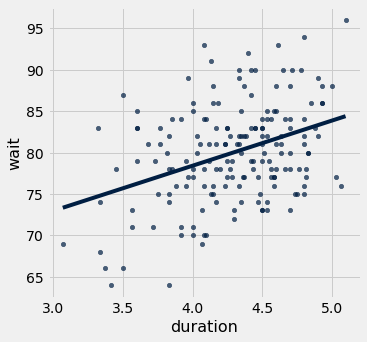

In [13]:
def standard_units(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def correlation(tbl):
    x_std, y_std = standard_units(tbl.column(0)), standard_units(tbl.column(1))
    return np.mean(x_std * y_std)

def fit_line(tbl):
    
    def objective_fn(slope, intercept):
        fitted = slope * tbl.column(0) + intercept
        return sum((tbl.column(1) - fitted) ** 2)
    
    m = minimize(objective_fn)
    fit_slope = m[0]
    fit_intercept = m[1]
    return make_array(fit_slope, fit_intercept)

faithful = Table.read_table('faithful_inference.csv').where("duration", are.above_or_equal_to(3))
faithful.scatter('duration', fit_line=True)
faithful

### Finding the Bootstrap Prediction Interval

Suppose we're tourists at Yellowstone, and we'd like to know how long we'll have to wait for the next Old Faithful eruption.  We decide to use our regression line to make some predictions for the waiting times.  But just as we're uncertain about the slope of the true regression line, we're also uncertain about the predictions we'd make based on the true regression line.

#### Question 7 (yes, 7 is the first question)

Define the function `fitted_value`.  It should take 2 arguments:

1. A table with 2 columns.  We'll be predicting the values in the second column using the first.
2. A number, the value of the predictor variable for which we'd like to make a prediction.

Make sure to use your `fit_line` function. 

In [18]:
def fitted_value(table, given_x):
    # The staff solution took 4 lines of code.
    ...

# Here's an example of how fitted_value is used.  This should
# compute the prediction for the wait time of an eruption that lasts 
# two minutes .
two_minutes_wait = fitted_value(faithful, 2)
two_minutes_wait

In [19]:
check('part2_tests/q3_7.py')


#### Question 8

The park ranger tells us that the most recent eruption lasted 6 minutes. Using your function above, assign the variable `most_recent_wait` to the predicted wait time. 

In [20]:
most_recent_wait = ...
most_recent_wait

Ellipsis

In [21]:
check('part2_tests/q3_8.py')


Juan, a fellow tourist, raises the following objection to your prediction:

> "Your prediction depends on your sample of 272 eruptions.  Couldn't your prediction have been different if you had happened to have a different sample of eruptions?"

Having read section [16.3](https://www.inferentialthinking.com/chapters/16/3/prediction-intervals.html) of the textbook, you know just the response!

#### Question 9

Define the function `bootstrap_lines`.  It should take two arguments:
1. A table with two columns.  As usual, we'll be predicting the second column using the first.
2. An integer, a number of bootstraps to run.

It should return a *table* whose first column, `"Slope"`, contains the given number of bootstrapped slopes, and whose second column, `"Intercept"`, contains the corresponding bootstrapped intercepts.  Each slope and intercept should come from a regression line that predicts column 2 from column 1 of a resample of the given table.  The table should have 1 row for each bootstrap replication.

In [22]:
def bootstrap_lines(tbl, num_bootstraps):
    ...

# When you're done, this code should produce the slopes
# and intercepts of 1000 regression lines computed from
# resamples of the faithful table.
regression_lines = bootstrap_lines(faithful, 1000)
regression_lines

#### Question 10

Create an array called `predictions_for_six`.  It should contain 1000 numbers.  Each number should be the predicted waiting time after an eruption with a duration of 6 minutes, using a different bootstrapped regression line. Hint: use `regression_lines` from the previous questions.

TypeError: '<' not supported between instances of 'ellipsis' and 'float'

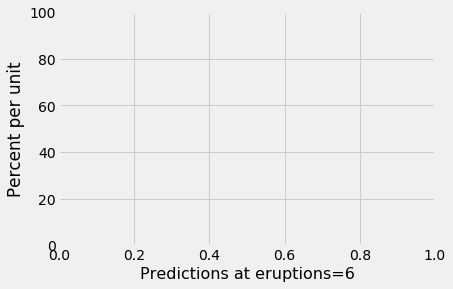

In [23]:
predictions_for_six = ...

# This will make a histogram of your predictions:
table_of_predictions = Table().with_column('Predictions at eruptions=6', predictions_for_six)
table_of_predictions.hist('Predictions at eruptions=6', bins=20)

#### Question 11

Create a 95 percent confidence interval for these predictions.

In [24]:
lower_bound = ...
upper_bound = ...

print('95% Confidence interval for predictions for x=6: (', lower_bound,",", upper_bound, ')')

95% Confidence interval for predictions for x=6: ( Ellipsis , Ellipsis )


In [25]:
check('part2_tests/q3_11.py')


#### Question 12

Look at the scatter plot of the data at the start of this exercise. 
Determine which of the following are true, then set `question_12_choice` to an array consisting of the numbers of statements that are true. For example, if you think that 1 and 2 are true but 3 is false, you'd assign `question_12_choice` to be an array consisting of the values 1 and 2.

Statement 1: This confidence covers 95 percent of waiting times of eruptions in `faithful` that had an eruption duration of 6 minutes.

Statement 2: This interval gives a sense of how much actual wait times differ from your prediction.

Statement 3: The confidence interval quantifies our uncertainty in our estimate of what the true regression line would predict.

In [26]:
question_12_choice = []

In [27]:
check('part2_tests/q3_12.py')

95% Confidence interval for predictions for x=6: ( Ellipsis , Ellipsis )
[]
Question 1:


Question 2:


Question 3:


Question 4:


Question 5:


Question 6:


Question 7:


0.0

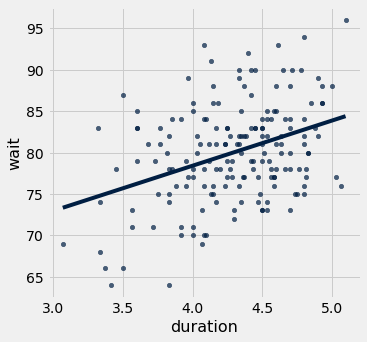

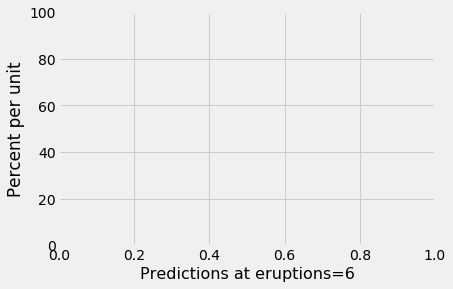

In [28]:
# For your convenience, you can run this cell to run all the tests at once!
import glob
from gofer.ok import grade_notebook
if not globals().get('__GOFER_GRADER__', False):
    display(grade_notebook('Practice.ipynb', sorted(glob.glob('part*_tests/q*.py'))))